In [8]:
# wiomenmoxingfaileddezuoweijiaqiangxunlian GAN, shencheng shibiebuliaodehuibengdiao

In [9]:
import os

In [16]:
# when writing log, thought about what if we make it different so we flip the color
from PIL import Image
import os
import imageio.v2 as imageio
import numpy as np
import cv2

path = "/home/wg25r/fastdata/fullmoca/MoCA-Video-Train/"
rgb_dir = "./video_rgb_"
alpha_dir = "./video_alpha"

if os.path.exists(rgb_dir):
    os.system(f"rm -rf {rgb_dir}")
os.makedirs(rgb_dir)

if os.path.exists(alpha_dir):
    os.system(f"rm -rf {alpha_dir}")
os.makedirs(alpha_dir)

# for video in os.listdir(path):
def process_video(video):
    frame_dir = os.path.join(path, video, "Frame")
    gt_dir = os.path.join(path, video, "GT")
    if not (os.path.isdir(frame_dir) and os.path.isdir(gt_dir)):
        return
    frames = sorted(f for f in os.listdir(frame_dir) if f.lower().endswith(".jpg"))
    if len(frames) < 37:
        print(f"Video {video} has less than 37 frames, skipping...")
        return

    for idx in range(len(frames) // 37):
        seg_frames = frames[idx * 37:(idx + 1) * 37]

        rgb_out_path = os.path.join(rgb_dir, f"{video}_{idx:03d}.mp4")
        writer_rgb = imageio.get_writer(rgb_out_path, fps=24)
        for i, f in enumerate(seg_frames):
            img = imageio.imread(os.path.join(frame_dir, f))
            img_resized = Image.fromarray(img).resize((848, 480))
            writer_rgb.append_data(np.array(img_resized).astype(np.uint8))
        writer_rgb.close()

        alpha_out_path = os.path.join(alpha_dir, f"{video}_{idx:03d}.mp4")
        writer_alpha = imageio.get_writer(alpha_out_path, fps=24)
        for i, f in enumerate(seg_frames):
            alpha_name = os.path.splitext(f)[0] + '.png'
            mask = np.array(imageio.imread(os.path.join(gt_dir, alpha_name)))
            mask_resized = cv2.resize(mask, (848, 480), interpolation=cv2.INTER_NEAREST)
            img = np.array(imageio.imread(os.path.join(frame_dir, f)))
            img = cv2.resize(img, (848, 480), interpolation=cv2.INTER_NEAREST)
            foreground = np.where(mask_resized[:,:,None] > 0, img, 0).astype(int)
            foreground = np.clip(foreground, 0, 255).astype(np.uint8)
                        
            img_clipped = np.where(mask_resized[:,:,None] > 0, 255, 0)
                        
            writer_alpha.append_data(img_clipped.astype(np.uint8))
        writer_alpha.close()
    return img_clipped.astype(int), np.array(img_resized).astype(int)


In [10]:
videos = os.listdir(path)

a, b = process_video(videos[0]) 

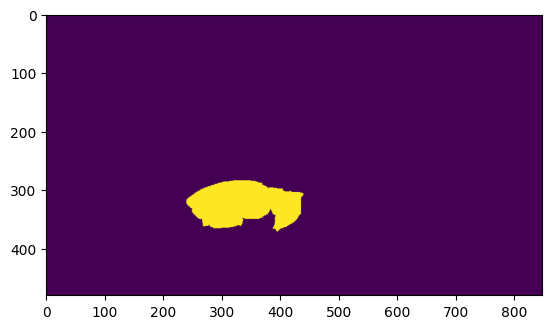

In [11]:
import matplotlib.pyplot as plt
plt.imshow(a)

In [17]:

# use a pool of 64 processes
from multiprocessing import Pool
pool = Pool(processes=64)
# map the function to the list of videos
pool.map(process_video, videos)
pool.close()
pool.join() 

Video flounder_3 has less than 37 frames, skipping...


In [4]:
from openai import OpenAI
from PIL import Image
import io
import base64

def capture_image(imgs, filename):
    
    client = OpenAI()
    
    base64s = []
    for img in imgs:
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG")
        image_data = buffer.getvalue()
        base64_image = base64.b64encode(image_data).decode('utf-8')
        image_url = f"data:image/jpeg;base64,{base64_image}"
        base64s.append(image_url)
        
    response = client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[
        {
        "role": "user",
        "content": [
            *[{
            "type": "image_url",
            "image_url": {
                "url": image_url
            }
            } for image_url in base64s],
            {
            "type": "text",
            "text": "Describe in 2-3 setence this image such that the prompt will be used to generate an video. Mention motion, the object might be hard to see. the filename is " + filename + ", filename might has other things than the animal. Do not mention filename just the animal name. The object might be hard to see (mention this) and blended into the envirement. Mention the animal is camflague and blend into the envirement for texture, color, and shape. Mention the animal's motion, but do not mention this makes it easy to spot."
            }
        ]
        },
    ],
    )
    return response.choices[0].message.content

import os
import cv2
videos = os.listdir("./video_rgb_")

def get_prompt(video):
    video_path = os.path.join("./video_rgb", video)
    
    cap = cv2.VideoCapture(video_path)
    frames = []
    # get first, middle, and last frame
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    middle_frame = total_frames // 2
    for i in [0, middle_frame, total_frames - 1]:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
    cap.release()
    # Convert frames to PIL images
    imgs = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in frames]
    # Capture image and get prompt
    prompt = capture_image(imgs, video) 
    
    with open(os.path.join("./video_rgb", video.replace(".mp4", ".txt")), "w") as f:
        f.write(prompt)
    # print(prompt)
    return prompt
videos = os.listdir("./video_rgb_")
print(len(videos))
# use a pool of 30 processes
from multiprocessing import Pool
if __name__ == "__main__":
    with Pool(30) as p:
        prompts = p.map(get_prompt, videos)
    print(prompts)

# get_prompt("crab_1_000.mp4")

3423


['The video features a camouflaged spider that blends seamlessly into its environment through matching texture, color, and shape, making it difficult to spot. The spider exhibits slow, deliberate movements as it navigates its surroundings, with its motion subtly shifting its position against the textured background. Despite its slight movements, the animal remains well camouflaged within the environment, challenging viewers to distinguish it from its surroundings.', 'A camouflaged animal subtly moves through the environment, its texture, color, and shape blending seamlessly into the surroundings, making it difficult to spot. The motion appears gentle and natural as it navigates through the scene, with its presence subtly shimmering against the textured background.', 'The video depicts a camouflaged caterpillar subtly moving across a textured natural environment, with its body blending seamlessly into the surrounding colors, textures, and shapes. Its motion is slow and deliberate, makin

In [20]:
import subprocess
import os
from PIL import Image
import tqdm
os.makedirs("single_frame", exist_ok=True)
image_path = "/home/wg25r/fastdata/COD/COD10K-v3/Train/Image"
for img in tqdm.tqdm(os.listdir(image_path)):
    img_path = os.path.join(image_path, img)
    im = Image.open(img_path)
    width, height = im.size
    if width < 848 or height < 480:
        scale_factor = max(848/width, 480/height)
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        vf_option = f"scale={new_width}:{new_height},crop=848:480"
    else:
        vf_option = "crop=848:480"
        
    subprocess.run([
        "ffmpeg",
        "-loglevel", "error",
        "-loop", "1",
        "-i", img_path,
        "-vf", vf_option,
        "-c:v", "libx264",
        "-t", "1",
        "-pix_fmt", "yuv420p",
        os.path.join("single_frame", img.replace(".jpg", ".mp4")),
        "-y",
    ])
    # with open(os.path.join("single_frame", img.replace(".jpg", ".txt")), "w") as f:
    #     f.write(img)


  4%|▍         | 115/2991 [00:42<17:53,  2.68it/s][Parsed_crop_1 @ 0x59f65e093a80] Invalid too big or non positive size for width '848' or height '480'
[Parsed_crop_1 @ 0x59f65e093a80] Failed to configure input pad on Parsed_crop_1
Error reinitializing filters!
Failed to inject frame into filter network: Invalid argument
Error while processing the decoded data for stream #0:0
  6%|▌         | 173/2991 [01:03<20:58,  2.24it/s][Parsed_crop_1 @ 0x644bef04fa00] Invalid too big or non positive size for width '848' or height '480'
[Parsed_crop_1 @ 0x644bef04fa00] Failed to configure input pad on Parsed_crop_1
Error reinitializing filters!
Failed to inject frame into filter network: Invalid argument
Error while processing the decoded data for stream #0:0
 21%|██        | 634/2991 [03:54<14:09,  2.77it/s][Parsed_crop_1 @ 0x57e51e4813c0] Invalid too big or non positive size for width '848' or height '480'
[Parsed_crop_1 @ 0x57e51e4813c0] Failed to configure input pad on Parsed_crop_1
Error rein

In [47]:
import subprocess
import os
from PIL import Image
import tqdm 
os.makedirs("video_rgb_", exist_ok=True)
image_path = "/home/wg25r/fastdata/COD/COD10K-v3/Train/Image"
def process_image(img):
    img_path = os.path.join(image_path, img)
    im = Image.open(img_path)
    width, height = im.size
    scale_factor = max(848/width, 480/height)
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    vf_option = f"scale={new_width}:{new_height},crop=848:480"

        
    result = subprocess.run([
        "ffmpeg",
        "-loglevel", "error",
        "-loop", "1",
        "-i", img_path,
        "-vf", vf_option,
        "-c:v", "libx264",
        "-t", "1",
        "-pix_fmt", "yuv420p",
        os.path.join("video_rgb_", img.replace(".jpg", ".mp4")),
        "-y",
    ], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode != 0:
        print(result.stderr)
        os.remove(os.path.join("video_rgb_", img.replace(".jpg", ".mp4")))

images = os.listdir(image_path)
images = [i for i in images if not "NonCAM" in i]

# use a pool of 30 processes
from multiprocessing import Pool
if __name__ == "__main__":
    with Pool(30) as p:
        p.map(process_image, images)

[Parsed_crop_1 @ 0x5ad72d01d2c0] Invalid too big or non positive size for width '848' or height '480'
[Parsed_crop_1 @ 0x5ad72d01d2c0] Failed to configure input pad on Parsed_crop_1
Error reinitializing filters!
Failed to inject frame into filter network: Invalid argument
Error while processing the decoded data for stream #0:0

[Parsed_crop_1 @ 0x5eb0a6367b00] Invalid too big or non positive size for width '848' or height '480'
[Parsed_crop_1 @ 0x5eb0a6367b00] Failed to configure input pad on Parsed_crop_1
Error reinitializing filters!
Failed to inject frame into filter network: Invalid argument
Error while processing the decoded data for stream #0:0

[Parsed_crop_1 @ 0x56334ad15500] Invalid too big or non positive size for width '848' or height '480'
[Parsed_crop_1 @ 0x56334ad15500] Failed to configure input pad on Parsed_crop_1
Error reinitializing filters!
Failed to inject frame into filter network: Invalid argument
Error while processing the decoded data for stream #0:0

[Parsed_cr

In [48]:
import subprocess
import os
from PIL import Image
import tqdm 
os.makedirs("video_alpha", exist_ok=True)
image_path = "/home/wg25r/fastdata/COD/COD10K-v3/Train/GT_Instance"
def process_image(img):
    img_path = os.path.join(image_path, img)
    im = Image.open(img_path)
    width, height = im.size
    scale_factor = max(848/width, 480/height)
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    vf_option = f"scale={new_width}:{new_height},crop=848:480"

    # Binarize the image
    im = im.convert('L') # Ensure grayscale 
    # Binarize: pixels > 0 become 255 (white), others 0 (black)
    im = np.where(np.array(im) > 0, 255, 0).astype(np.uint8)
    im_bin = Image.fromarray(im) # Convert back to PIL Image
    
    # Use tempfile for the binarized image
    temp_f = None # Initialize to None
    try:
        # Create a temporary file to save the binarized image
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_f:
            im_bin.save(temp_f.name)
            temp_img_path = temp_f.name # Get the path to the temporary file

        # Modify the ffmpeg command to use the temporary binarized file and include vf_option
        result = subprocess.run([
            "ffmpeg",
            "-loglevel", "error",
            "-loop", "1",
            "-i", temp_img_path, # Use the temporary binarized image as input
            "-vf", vf_option,    # Apply scaling/cropping
            "-c:v", "libx264",
            "-t", "1",
            "-pix_fmt", "yuv420p",
            os.path.join("video_alpha", os.path.basename(img_path).replace(".png", ".mp4")), # Use original base name for output
            "-y",
        ], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

        if result.returncode != 0:
            print(f"FFmpeg error for {img}: {result.stderr}")
            output_path = os.path.join("video_alpha", os.path.basename(img_path).replace(".png", ".mp4"))
            if os.path.exists(output_path):
                 os.remove(output_path) # Clean up potentially corrupted output

    finally:
        # Clean up the temporary file if it was created
        if temp_f and os.path.exists(temp_f.name):
            os.remove(temp_f.name)

    # The original ffmpeg call is replaced by the one inside the try block
    return # Exit function here as processing is done

# The rest of the original ffmpeg call below this selection is now redundant
# because it's handled within the try block above.
# We add a 'return' above to prevent executing the code below the placeholder.

images = os.listdir(image_path)
# use a pool of 30 processes
images = [i for i in images if not "NonCAM" in i]
from multiprocessing import Pool
import tempfile
if __name__ == "__main__":
    with Pool(30) as p:
        p.map(process_image, images)

FFmpeg error for COD10K-CAM-3-Flying-56-Cicada-3514.png: [Parsed_crop_1 @ 0x62069493ea00] Invalid too big or non positive size for width '848' or height '480'
[Parsed_crop_1 @ 0x62069493ea00] Failed to configure input pad on Parsed_crop_1
Error reinitializing filters!
Failed to inject frame into filter network: Invalid argument
Error while processing the decoded data for stream #0:0

FFmpeg error for COD10K-CAM-2-Terrestrial-47-Tiger-2882.png: [Parsed_crop_1 @ 0x557caf203f40] Invalid too big or non positive size for width '848' or height '480'
[Parsed_crop_1 @ 0x557caf203f40] Failed to configure input pad on Parsed_crop_1
Error reinitializing filters!
Failed to inject frame into filter network: Invalid argument
Error while processing the decoded data for stream #0:0

FFmpeg error for COD10K-CAM-2-Terrestrial-40-Rabbit-2359.png: [Parsed_crop_1 @ 0x5ea2ce384540] Invalid too big or non positive size for width '848' or height '480'
[Parsed_crop_1 @ 0x5ea2ce384540] Failed to configure input

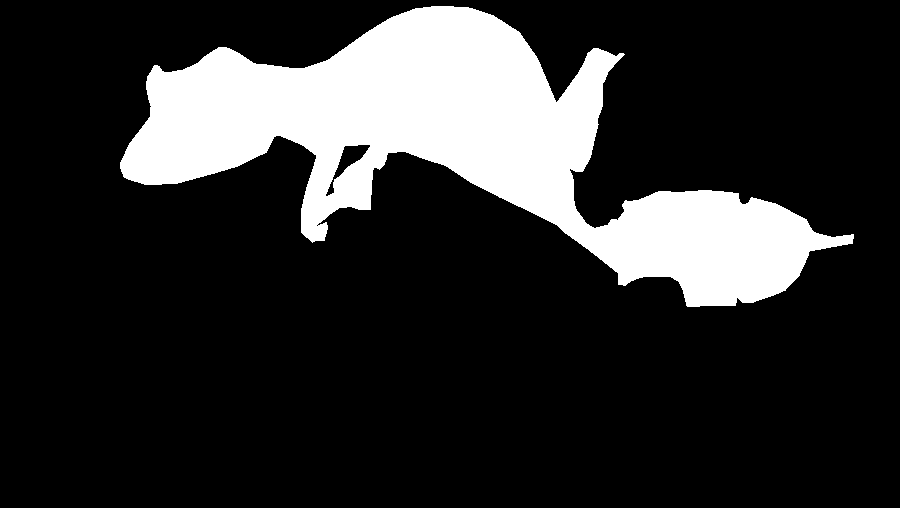

In [40]:
path = "/home/wg25r/fastdata/COD/COD10K-v3/Train/GT_Instance/"
file = path + os.listdir(path)[0]
im = Image.open(file).convert('L')
im = np.where(np.array(im) > 0, 255, 0).astype(np.uint8)
im_bin = Image.fromarray(im)
im_bin

In [ ]:

import subprocess
import os
from PIL import Image
import tqdm 
os.makedirs("video_rgb_", exist_ok=True)
image_path = "/home/wg25r/fastdata/COD/COD10K-v3/Train/Image"
def process_image(img):
    img_path = os.path.join(image_path, img)
    im = Image.open(img_path)
    